In [369]:
%matplotlib inline

import pandas as pd
import numpy as np
from enum import Enum

from sklearn import linear_model
import scipy as sp

In [481]:
data.head(5)

,PType,Age,Gender,Education,Answer
0,ÇDÜY,1,1,3,"[SCORETYPE.SEZGISEL, SCORETYPE.DISADONUK, SCOR..."
1,ÇDÜY,1,0,2,"[SCORETYPE.DUYUSAL, SCORETYPE.ICEDONUK, SCORET..."
2,ŞDÜY,1,0,2,"[SCORETYPE.SEZGISEL, SCORETYPE.ICEDONUK, SCORE..."
3,ŞSÜY,1,1,2,"[SCORETYPE.SEZGISEL, SCORETYPE.DISADONUK, SCOR..."
4,ÇSUY,2,1,3,"[SCORETYPE.SEZGISEL, SCORETYPE.DISADONUK, SCOR..."


<h1> ENUMS TO CODE DATA </h1>

In [192]:
# ENUMS:
class AgeRange(Enum):
    MINUS18 = 0
    B2130 = 1
    B3140 = 2
    B4150 = 3
    PLUS50 = 4

class Education(Enum):
    HSCHOOL = 0
    JCOLLEGE = 1
    UNIVERSITY = 2
    MASTERS = 3
    PHD = 4
    OTHER = 5
    
class Gender(Enum):
    MALE = 0
    FEMALE = 1

class SCORETYPE(Enum):
    ICEDONUK = 0
    DISADONUK = 1
    DUYUSAL = 2
    SEZGISEL = 3
    DUSUNSEL = 4
    DUYGUSAL = 5
    YARGISAL = 6
    ALGISAL = 7

<h1> CLEAN DATA </h1>

In [464]:
data = pd.read_csv("kpa-data.csv", sep=";", names = ["PType", "Age", "Gender", "Education", "Answer"]);

# Remove First 3 rows
for dataIndex in range(3):
    data = data.drop([dataIndex])
data = data.reset_index(drop = True)

dataRowCount = data.shape[0]

#Remove commas from answer column
for row in range(dataRowCount):
    data["Answer"][row] = data["Answer"][row].replace(",", "")

# Convert String Labels to Enums
for row in range(dataRowCount):
    if data["Age"][row] == "21-30":
        data["Age"][row] = AgeRange.B2130.value
    elif data["Age"][row] == "31-40":
        data["Age"][row] = AgeRange.B3140.value
    elif data["Age"][row] == "41-50":
        data["Age"][row] = AgeRange.B4150.value
    elif data["Age"][row] == "20 ve altı":
        data["Age"][row] = AgeRange.MINUS18.value
    elif data["Age"][row] == "50 ve yukarısı":
        data["Age"][row] = AgeRange.PLUS50.value

for row in range(dataRowCount):
    if data["Education"][row] == "Lise":
        data["Education"][row] = Education.HSCHOOL.value
    elif data["Education"][row] == "Yüksek Okul (2 yıl)":
        data["Education"][row] = Education.JCOLLEGE.value
    elif data["Education"][row] == "Üniversite":
        data["Education"][row] = Education.UNIVERSITY.value
    elif data["Education"][row] == "Yüksek Lisans":
        data["Education"][row] = Education.MASTERS.value
    elif data["Education"][row] == "Doktora":
        data["Education"][row] = Education.PHD.value
    elif data["Education"][row] == "Lise öncesi":
        data["Education"][row] = Education.OTHER.value
        
for row in range(dataRowCount):
    if data["Gender"][row] == "Erkek":
        data["Gender"][row] = Gender.MALE.value
    elif data["Gender"][row] == "Kadın":
        data["Gender"][row] = Gender.FEMALE.value

In [465]:
dataRowCount = data.shape[0]
newAnswerTotal = []
for row in range(dataRowCount):
    newAnswer = []
    for choice in range(len(data["Answer"][0])):
        if data["Answer"][row][choice] == "a":
            newAnswer.append(answerSheet[choice + 1][0])
        else:
            newAnswer.append(answerSheet[choice + 1][1])
    newAnswerTotal.append(newAnswer)

for row in range(dataRowCount):
    data["Answer"][row] = newAnswerTotal[row]

<h1> CALCULATE CORRELATION AND PLOT IT </h1>

In [ ]:
dataRowCount = data.shape[0]
correlations = []
for questionNumber in range(32):
    firstScoreType = answerSheet[questionNumber + 1][0]
    secondScoreType = answerSheet[questionNumber + 1][1]
    correlations.append(findCorrelationBetweenQuestionAndScore(questionNumber, firstScoreType, secondScoreType)[0])


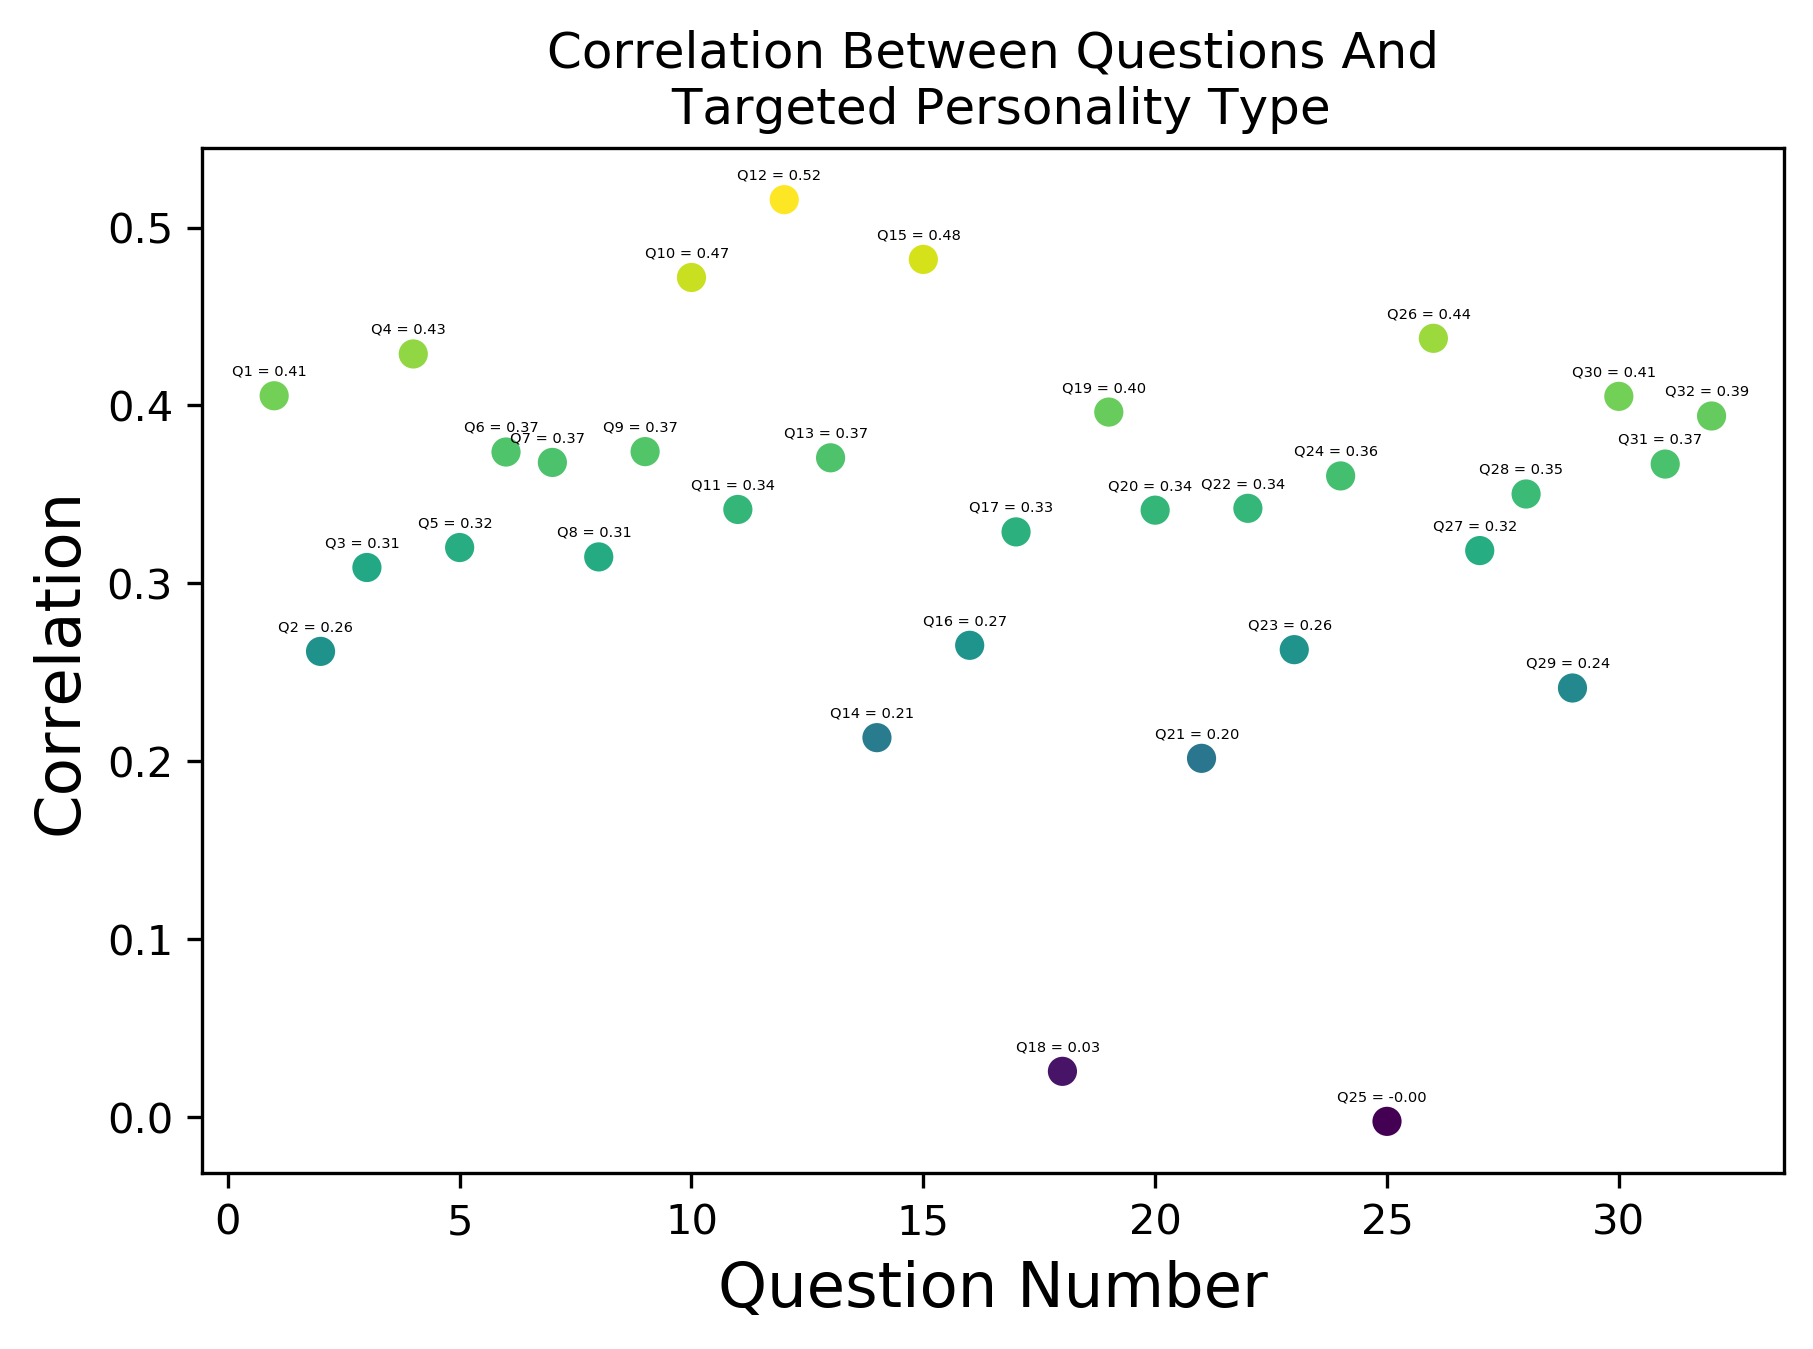

In [539]:
fig, ax = plt.subplots()
fig.facecolor = "w"
fig.edgecolr = "k"
fig.dpi = 300
fig.figsize = figsize=(8, 6)
fig.tight_layout()
ax.set_xlabel("Question Number", fontsize=15)
ax.set_ylabel('Correlation', fontsize=15)

ax.set_title('Correlation Between Questions And\n Targeted Personality Type')

scatterColor = correlations
plt.scatter(range(1,33), correlations, c = scatterColor)
for questionNumber in range(32):
    correlation2Digit = "{0:.2f}".format(correlations[questionNumber])
    plt.annotate(f"Q{questionNumber + 1} = {correlation2Digit}",(questionNumber,correlations[questionNumber]), textcoords="offset points",xytext=(10,5), ha='center', fontsize = 3.5) 
    # plt.text(questionNumber, correlations[questionNumber], f"Q{questionNumber} = {correlation2Digit}")



plt.show()
fig.savefig('Correlation Between Questions And\n Targeted Personality Type.png', bbox_inches='tight')

In [455]:
correlations

[0.40544894608345017,
 0.2617053239834149,
 0.308876621521911,
 0.42896060622845456,
 0.32010826455106445,
 0.3738176639196486,
 0.36796162093908713,
 0.31483347246125104,
 0.3740422969200441,
 0.4719704516760005,
 0.3415129323632727,
 0.5157266969762433,
 0.3705638930273139,
 0.2132007163556104,
 0.48212033298739454,
 0.2651223700382525,
 0.328896455657019,
 0.02556549962824569,
 0.39627529289718705,
 0.3411211461689767,
 0.20156998196756712,
 0.34214991373298964,
 0.2626841780312351,
 0.360368067494457,
 -0.0025626918712182405,
 0.43775445089229886,
 0.3183927356183277,
 0.35020971702595294,
 0.24111939971415391,
 0.40510938608063024,
 0.3670426996026796,
 0.3940721292238731]

In [477]:
def getScoreLetter(retrievedScoreType):
    scoreLetter = ""    
    if retrievedScoreType == SCORETYPE.ICEDONUK:
        scoreLetter = "Ç"
    elif retrievedScoreType == SCORETYPE.DISADONUK:
        scoreLetter = "Ş"
    elif retrievedScoreType == SCORETYPE.DUYUSAL:
        scoreLetter = "D"
    elif retrievedScoreType == SCORETYPE.SEZGISEL:
        scoreLetter = "S"
    elif retrievedScoreType == SCORETYPE.DUSUNSEL:
        scoreLetter = "Ü"
    elif retrievedScoreType == SCORETYPE.DUYGUSAL:
        scoreLetter = "U"
    elif retrievedScoreType == SCORETYPE.YARGISAL:
        scoreLetter = "Y"
    elif retrievedScoreType == SCORETYPE.ALGISAL:
        scoreLetter = "A"
    return scoreLetter

In [478]:
def findCorrelationBetweenQuestionAndScore(questionNumber, firstScoreType, secondScoreType):
    
    dataRowCount = data.shape[0]
    predictors = []
    
    for rowNumber in range(dataRowCount):
        if data["Answer"][rowNumber][questionNumber] == firstScoreType:        
            predictors.append(0)
        elif data["Answer"][rowNumber][questionNumber] == secondScoreType:
            predictors.append(1)
    predicted = []
    
    firstScoreLetter = getScoreLetter(firstScoreType)
    secondScoreLetter = getScoreLetter(secondScoreType)
    
    for rowNumber in range(dataRowCount):
        if firstScoreLetter in data["PType"][rowNumber]:        
            predicted.append(0)
        elif secondScoreLetter in data["PType"][rowNumber]:
            predicted.append(1)

    return sp.stats.pearsonr(predictors, predicted)

In [479]:
#Function return Personality type by subject's row number
def getPersonalityType(rowNumber):
    iceDonukCounter = 0
    duyusalCounter = 0
    dusunselCounter = 0
    yargisalCounter = 0
    disaDonukCounter = 0
    sezgiselCounter = 0
    duygusalCounter = 0
    algisalCounter = 0

    for choice in range(len(data["Answer"][rowNumber])):
        if data["Answer"][rowNumber][choice] == SCORETYPE.ICEDONUK:
            iceDonukCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.DISADONUK:
            disaDonukCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.DUYUSAL:
            duyusalCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.SEZGISEL:
            sezgiselCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.DUSUNSEL:
            dusunselCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.DUYGUSAL:
            duygusalCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.YARGISAL:
            yargisalCounter += 1
        elif data["Answer"][rowNumber][choice] == SCORETYPE.ALGISAL:
            algisalCounter += 1

    personalityType = ""

    if iceDonukCounter > disaDonukCounter:
        personalityType += "Ç"
    else:
        personalityType += "Ş"

    if sezgiselCounter > duyusalCounter:
        personalityType += "S"
    else:
        personalityType += "D"

    if  duygusalCounter > dusunselCounter:
        personalityType += "U"
    else:
        personalityType += "Ü"

    if algisalCounter > yargisalCounter:
        personalityType += "A"
    else:
        personalityType += "Y"
    
    return personalityType

In [482]:
answerSheet = {
    1 : [ SCORETYPE.SEZGISEL, SCORETYPE.DUYUSAL],
    2 : [ SCORETYPE.ICEDONUK, SCORETYPE.DISADONUK],
    3 : [ SCORETYPE.DUSUNSEL, SCORETYPE.DUYGUSAL],
    4 : [ SCORETYPE.YARGISAL, SCORETYPE.ALGISAL],
    5 : [ SCORETYPE.DUSUNSEL, SCORETYPE.DUYGUSAL],
    6 : [ SCORETYPE.ICEDONUK, SCORETYPE.DISADONUK],
    7 : [ SCORETYPE.YARGISAL, SCORETYPE.ALGISAL],
    8 : [ SCORETYPE.ALGISAL, SCORETYPE.YARGISAL],
    9 : [ SCORETYPE.YARGISAL, SCORETYPE.ALGISAL],
    10 : [ SCORETYPE.SEZGISEL, SCORETYPE.DUYUSAL],
    11 : [ SCORETYPE.ICEDONUK, SCORETYPE.DISADONUK],
    12 : [ SCORETYPE.DUSUNSEL, SCORETYPE.DUYGUSAL],
    13 : [ SCORETYPE.DUYUSAL, SCORETYPE.SEZGISEL],
    14 : [ SCORETYPE.DUYGUSAL, SCORETYPE.DUSUNSEL],
    15 : [ SCORETYPE.DISADONUK, SCORETYPE.ICEDONUK],
    16 : [ SCORETYPE.DUYUSAL, SCORETYPE.SEZGISEL],
    17 : [ SCORETYPE.DUYUSAL, SCORETYPE.SEZGISEL],
    18 : [ SCORETYPE.ALGISAL, SCORETYPE.YARGISAL],
    19 : [ SCORETYPE.DISADONUK, SCORETYPE.ICEDONUK],
    20 : [ SCORETYPE.DUSUNSEL, SCORETYPE.DUYGUSAL],
    21 : [ SCORETYPE.DUYUSAL, SCORETYPE.SEZGISEL],
    22 : [ SCORETYPE.ICEDONUK, SCORETYPE.DISADONUK],
    23 : [ SCORETYPE.ALGISAL, SCORETYPE.YARGISAL],
    24 : [ SCORETYPE.DUYGUSAL, SCORETYPE.DUSUNSEL],
    25 : [ SCORETYPE.DUSUNSEL, SCORETYPE.DUYGUSAL],
    26 : [ SCORETYPE.YARGISAL, SCORETYPE.ALGISAL],
    27 : [ SCORETYPE.DISADONUK, SCORETYPE.ICEDONUK],
    28 : [ SCORETYPE.SEZGISEL, SCORETYPE.DUYUSAL],
    29 : [ SCORETYPE.DUYGUSAL, SCORETYPE.DUSUNSEL],
    30 : [ SCORETYPE.SEZGISEL, SCORETYPE.DUYUSAL],
    31 : [ SCORETYPE.YARGISAL, SCORETYPE.ALGISAL],
    32 : [ SCORETYPE.DISADONUK, SCORETYPE.ICEDONUK]
}